In [2]:
%pip install pybind11==2.12


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install joblib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tqdm import tqdm
import joblib

# EDA

In [4]:
original_data = pd.read_csv("data/original_dataset.csv", encoding="utf-8")

In [5]:
original_data.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,7/15/2010,825532764,148,False,160000000,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,11/5/2014,701729206,169,False,165000000,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,7/16/2008,1004558444,152,False,185000000,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,12/15/2009,2923706026,162,False,237000000,...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,4/25/2012,1518815515,143,False,220000000,...,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


Приведем целевую переменную к задаче классификации

In [6]:
original_data['vote_average'] = original_data['vote_average'].apply(lambda x: int(x))

In [7]:
original_data.rename(columns={'vote_average': 'target'}, inplace=True)

Сразу же разделим нашу выборку на обучающую, с помощью которой будем тренировать модель, и тестовую, которую будем использовать впоследствии, чтобы получать предсказания.

In [8]:
train_data, test_data = train_test_split(original_data, test_size=0.5, stratify=original_data["target"], random_state=42)

In [9]:
test_data.to_csv("data/test_data.csv")

In [10]:
train_data.columns

Index(['id', 'title', 'target', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'budget', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords'],
      dtype='object')

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524287 entries, 1032216 to 465137
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    524287 non-null  int64  
 1   title                 524281 non-null  object 
 2   target                524287 non-null  int64  
 3   vote_count            524287 non-null  int64  
 4   status                524287 non-null  object 
 5   release_date          433606 non-null  object 
 6   revenue               524287 non-null  int64  
 7   runtime               524287 non-null  int64  
 8   adult                 524287 non-null  bool   
 9   budget                524287 non-null  int64  
 10  imdb_id               280248 non-null  object 
 11  original_language     524287 non-null  object 
 12  original_title        524281 non-null  object 
 13  overview              416405 non-null  object 
 14  popularity            524287 non-null  float64
 15 

In [12]:
train_data.head()

,id,title,target,vote_count,status,release_date,revenue,runtime,adult,budget,...,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
1032216,880753,Givin' It to My Step-Sis,0,0,Released,7/6/2021,0,71,True,0,...,en,Givin' It to My Step-Sis,You ever just need an outlet to let out some s...,0.622,She secretly loves it!,NaN,Manipulative Media,United States of America,English,stepsiblings
575874,1250721,Bis das Brot gefriert,0,0,Released,11/25/2006,0,0,False,0,...,de,Bis das Brot gefriert,NaN,0.600,NaN,NaN,NaN,NaN,NaN,NaN
1037893,884440,The Power of Envy,0,0,Released,NaN,0,5,False,0,...,en,The Power of Envy,A despicable hotel manager begins his descent ...,0.600,NaN,NaN,NaN,NaN,NaN,NaN
521261,1035736,Why Men Go Gay in L.A.,0,0,Released,4/22/2009,0,0,False,0,...,en,Why Men Go Gay in L.A.,"William Morgan has, like most men, had terribl...",0.683,NaN,NaN,NaN,NaN,NaN,NaN
991681,833316,The Abandoned Deity,0,0,Released,10/10/2019,0,15,False,0,...,zh,落難神像,The social impact of gambling affected Taiwane...,0.600,NaN,Animation,NaN,NaN,NaN,NaN


In [13]:
train_data.shape

(524287, 21)

Удалим все колонки, содержащие текстовые признаки, чтобы далее использовать стандартные подходы для табличных данных.

In [14]:
train_data.drop(columns=["title", "imdb_id", "original_language", "original_title", "overview", "tagline", "genres", "production_companies", "production_countries", "spoken_languages", "keywords"], inplace=True)

In [15]:
train_data.isna().sum()

id                  0
target              0
vote_count          0
status              0
release_date    90681
revenue             0
runtime             0
adult               0
budget              0
popularity          0
dtype: int64

Удалим дупликаты и пропуски

In [16]:
train_data.duplicated().sum()

np.int64(111)

In [17]:
train_data.dropna(inplace=True)
train_data.drop_duplicates(inplace=True)

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433552 entries, 1032216 to 1030767
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            433552 non-null  int64  
 1   target        433552 non-null  int64  
 2   vote_count    433552 non-null  int64  
 3   status        433552 non-null  object 
 4   release_date  433552 non-null  object 
 5   revenue       433552 non-null  int64  
 6   runtime       433552 non-null  int64  
 7   adult         433552 non-null  bool   
 8   budget        433552 non-null  int64  
 9   popularity    433552 non-null  float64
dtypes: bool(1), float64(1), int64(6), object(2)
memory usage: 33.5+ MB


Проведем анализ нечисловых признаков и целевой переменной.

## Целевая переменная

Посмотрим на распределение целевой переменной.

In [19]:
train_data['target'].value_counts()

target
0     262081
6      42352
5      39530
7      25040
4      17869
8      13150
10     11270
3       7441
2       6310
9       4793
1       3716
Name: count, dtype: int64

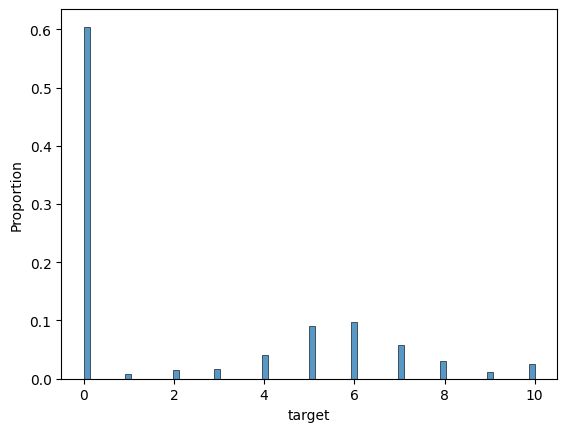

In [20]:
sns.histplot(data=train_data, x='target', stat='proportion')
plt.show()

Целевая переменная содержит серьезный дисбаланс. Проведем простую балансировку датасета, сократив объем 0, 5, 6 классов до 25000 объектов (так как в данной лабораторной работе требование на объем датасета >100000 объектов и мы можем пожертвовать объемом, чтобы не создавать большое количество искусственных данных).

In [21]:
target_counts = [0, 5, 6]
new_indices = []

for target in target_counts:
    indices = np.where(train_data["target"] == target)[0]
    sampled_indices = np.random.choice(indices, 25000, replace=False)
    new_indices.extend(sampled_indices)

new_indices = np.array(new_indices)

In [22]:
mask = ~train_data["target"].isin(target_counts)
train_data = pd.concat([train_data.iloc[new_indices], train_data[mask]])
train_data.reset_index(drop=True, inplace=True)

In [23]:
train_data["target"].value_counts()

target
7     25040
0     25000
5     25000
6     25000
4     17869
8     13150
10    11270
3      7441
2      6310
9      4793
1      3716
Name: count, dtype: int64

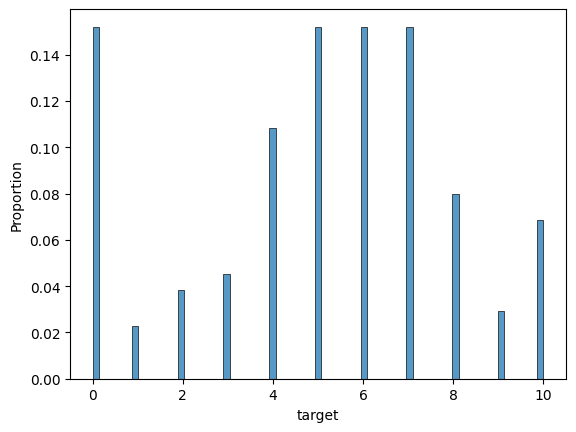

In [24]:
sns.histplot(data=train_data, x='target', stat='proportion')
plt.show()

В результате мы имеем более равномерное распределение признаков.

## Признак `adult`

In [25]:
train_data["adult"].value_counts()

adult
False    152514
True      12075
Name: count, dtype: int64

Приведем данный признак к типу `int`

In [26]:
train_data['adult'] = train_data['adult'].astype(int)

## Признак `status`

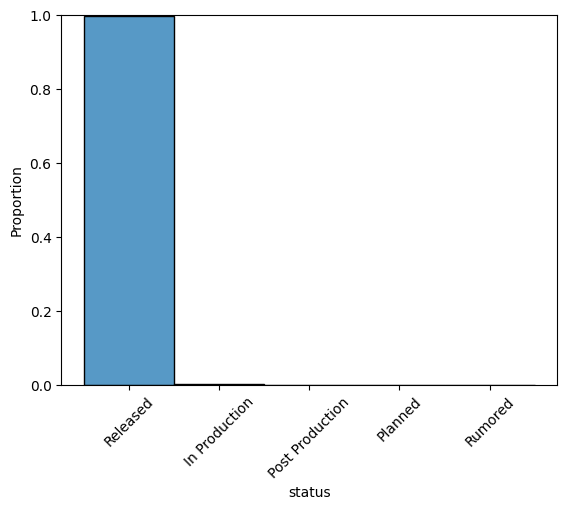

In [27]:
sns.histplot(data=train_data, x='status', stat='proportion')
plt.ylim((0,1))
plt.xticks(rotation=45)
plt.show()

Несмотря на то, что распределение признака неравномерное, оставим его, чтобы далее проанализировать значимость.

## Признак `release_date`

In [28]:
train_data["release_date"].value_counts()

release_date
1/1/2006     488
1/1/2009     424
1/1/2008     405
1/1/2007     394
1/1/2010     388
            ... 
4/16/1940      1
7/30/1940      1
5/14/1924      1
2/28/1929      1
3/3/1916       1
Name: count, Length: 30074, dtype: int64

Уницифируем вид даты

In [29]:
train_data["release_date"] = pd.to_datetime(train_data["release_date"], errors="coerce")
train_data["release_date"].isnull().sum()
train_data.dropna(inplace=True)

На мой взгляд, месяц и день выхода фильма в большинстве своем является шумом, поэтому оставим только признак с годом выхода фильма.

In [30]:
train_data["release_year"] = train_data["release_date"].dt.year
train_data.drop(columns="release_date", inplace=True)

# Выбор модели

In [31]:
# Снова разделим нашу выборку на тренировочную и тестовую, чтобы всю KFold валидацию делать на небольшой тестовой выборке, а обучать итоговую модель на тренировочной. 
train_dataset, test_dataset = train_test_split(train_data, test_size=0.3, random_state=42)

По `KFold` (k=10) кросс-валидации выберем модель. В качестве способа кодировки признаков воспользуемся `OneHotEncoding`.

| Модели |
|----------|
| `LogisticRegression` |
| `DecisionTreeClassifier` |
| `RandomForestClassifier` |
| `GradientBoostingClassifier` |


In [32]:
X = test_dataset.drop(columns='target')
y = np.array(test_dataset['target'])

In [33]:
X.shape

(49192, 9)

In [34]:
models = {
    'LogisticRegression': lambda: LogisticRegression(max_iter=100),
    'DecisionTreeClassifier': lambda: DecisionTreeClassifier(),
    'RandomForestClassifier': lambda: RandomForestClassifier(),
    'GradientBoostingClassifier': lambda: GradientBoostingClassifier()
}

metrics = {}
kf = KFold(n_splits=2, shuffle=True, random_state=42)

encoder_method = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
column_transformer = ColumnTransformer([
    ('ohe', encoder_method, ['status']),
], remainder="passthrough")

for train_index, val_index in tqdm(kf.split(X)):
    X_train, y_train = X.iloc[train_index, :], y[train_index]
    X_val, y_val = X.iloc[val_index, :], y[val_index]

    for model_name, model_creator in models.items():
        pipeline = Pipeline(steps=[
            ('ohe', column_transformer),
            ('scaling', StandardScaler()),
            ('model', model_creator())
        ])
        
        pipeline.fit(X_train, y_train)
        f1 = f1_score(y_val, pipeline.predict(X_val), average='weighted')

        if model_name not in metrics:
            metrics[model_name] = []
        metrics[model_name].append(f1)

0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
1it [00:31, 31.12s/it]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

In [35]:
for experiment in metrics:
    metrics[experiment]=np.mean(metrics[experiment])
pd.DataFrame.from_dict(metrics, orient='index').rename(columns={0: 'f1 score'}).sort_values(by='f1 score', ascending=False)

,f1 score
GradientBoostingClassifier,0.362064
RandomForestClassifier,0.356320
DecisionTreeClassifier,0.328822
LogisticRegression,0.190747


Будем работать дальше с 2 лучшими моделями: `GradientBoostingClassifier` и `RandomForestClassifier`.

# Отбор признаков

In [36]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ['status']),
], remainder="passthrough")
column_transformer.fit(X, y)
X = pd.DataFrame(column_transformer.transform(X), columns=column_transformer.get_feature_names_out())

In [37]:
X.shape

(49192, 13)

В данный момент у нас есть достаточно большое количество признаков. Попробуем отобрать наиболее важные признаки по весам логистической регрессии.

In [38]:
pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', LogisticRegression())
])
pipeline.fit(X, y)
coef = pipeline.steps[1][1].coef_[0]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Визуализируем абсолютные значения весов логистической регрессии.

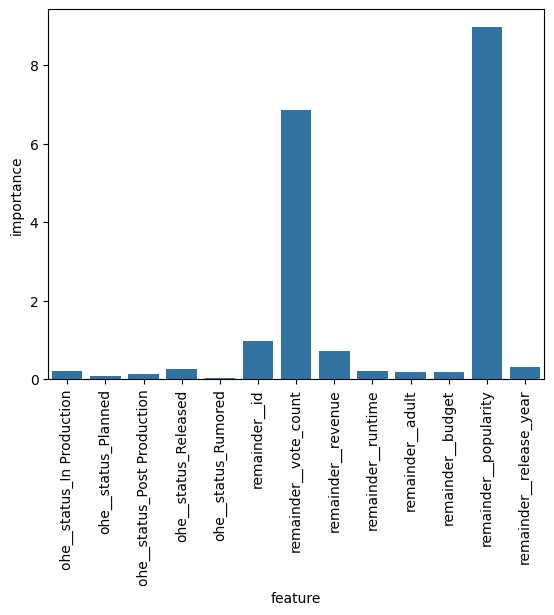

In [39]:
sns.barplot(data=pd.DataFrame.from_dict({'importance': np.abs(coef), 'feature': X.columns}), x='feature', y='importance')
plt.xticks(rotation=90)
plt.show()

Мы отберем признаки, у которых $importance > C$, где $C$ какой-то порог. По `k-Fold` (k=10) кросс-валидации найдем такой порог.

In [40]:
f1 = {i: [] for i in sorted(np.abs(coef))[:-1]}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, val_index in tqdm(kf.split(X)):
    for C in f1:
        X_train = X.iloc[train_index, np.abs(coef) > C]
        y_train = y[train_index]
        X_val = X.iloc[val_index, np.abs(coef) > C]
        y_val = y[val_index]

        pipeline = Pipeline(steps=[
            ('scaling', StandardScaler()),
            ('regression', LogisticRegression(solver='lbfgs'))
        ])
        pipeline.fit(X_train, y_train)

        f1[C].append(f1_score(y_val, pipeline.predict(X_val), average='weighted'))

for C in f1:
    f1[C] = np.mean(f1[C])

f1 = pd.DataFrame.from_dict(f1, orient='index').reset_index().rename(columns={'index': 'C', 0: 'f2-score'})

print(f1)

0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

           C  f2-score
0   0.033542  0.191557
1   0.070569  0.191963
2   0.116764  0.191618
3   0.168409  0.187283
4   0.170655  0.186776
5   0.205121  0.186881
6   0.207701  0.185667
7   0.248546  0.185104
8   0.302559  0.170138
9   0.717951  0.169883
10  0.956175  0.148707
11  6.854738  0.130922


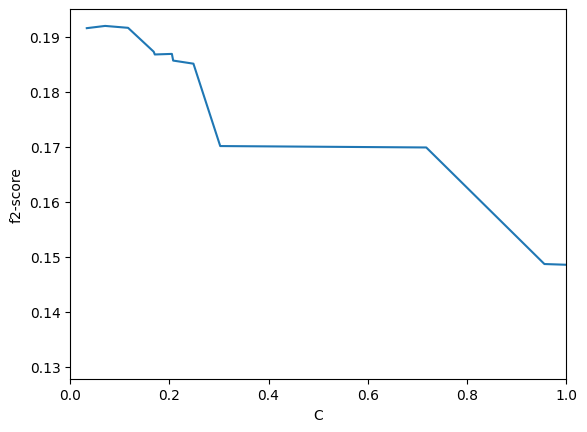

In [41]:
sns.lineplot(data=f1, x='C', y='f2-score')
plt.xlim(0, 1)
plt.show()

Видно, что при $0<C<0.3$ происходят хаотичные коллебания. Возьмем порог $C=0.3$, после которого качество модели начинает ухудшаться.

In [42]:
X = X.iloc[:, np.abs(coef)>0.3]

In [43]:
X.columns

Index(['remainder__id', 'remainder__vote_count', 'remainder__revenue',
       'remainder__popularity', 'remainder__release_year'],
      dtype='object')

In [44]:
len(X.columns)

5

# Обучение моделей

Так как мы выбрали лучшие модели и отобрали признаки, то можем посмотреть, какое качество получится теперь.

In [45]:
models = {
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

metrics = {}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in tqdm(kf.split(X)):
    for model in models:
        X_train = X.iloc[train_index, :]
        y_train = y[train_index]
        X_val = X.iloc[val_index, :]
        y_val = y[val_index]

        pipeline = Pipeline(steps=[
            ('scaling', StandardScaler()),
            ('classifier', models[model]())
        ])
        pipeline.fit(X_train, y_train)

        if model not in metrics:
            metrics[model] = []
        
        f1 = f1_score(y_val, pipeline.predict(X_val), average='weighted')
        metrics[model].append(f1)

10it [07:56, 47.65s/it]


In [46]:
for experiment in metrics:
    metrics[experiment]=np.mean(metrics[experiment])
pd.DataFrame.from_dict(metrics, orient='index').rename(columns={0: 'f1 score'}).sort_values(by='f1 score', ascending=False)

,f1 score
GradientBoostingClassifier,0.344753
RandomForestClassifier,0.332879


# Обучаем финальную модель GradientBoostingClassifier, которая показала себя лучше всего 

In [47]:
final_train_data, final_test_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train = final_train_data.drop(columns='target')
y_train = np.array(final_train_data['target'])

X_test = final_test_data.drop(columns='target')
y_test = np.array(final_test_data['target'])

In [48]:
X_train.head()

,id,vote_count,status,revenue,runtime,adult,budget,popularity,release_year
98387,331957,1,Released,0,0,0,0,0.600,1957
161720,324232,1,Released,0,92,0,0,0.600,2009
164388,1372,6999,Released,171720398,143,0,100000000,33.641,2006
34850,73215,30,Released,0,90,0,0,3.056,2011
115473,717218,6,Released,0,26,0,0,1.176,2019


In [49]:
encoder_method = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
column_transformer = ColumnTransformer([
    ('ohe', encoder_method, ['status']),
], remainder="passthrough")
column_transformer.fit(X_train, y_train)
X_train = pd.DataFrame(column_transformer.transform(X_train), columns=column_transformer.get_feature_names_out())

X_test = pd.DataFrame(column_transformer.transform(X_test), columns=column_transformer.get_feature_names_out())

In [50]:
X_train.head()

,ohe__status_In Production,ohe__status_Planned,ohe__status_Post Production,ohe__status_Released,ohe__status_Rumored,remainder__id,remainder__vote_count,remainder__revenue,remainder__runtime,remainder__adult,remainder__budget,remainder__popularity,remainder__release_year
0,0.0,0.0,0.0,1.0,0.0,331957.0,1.0,0.0,0.0,0.0,0.0,0.600,1957.0
1,0.0,0.0,0.0,1.0,0.0,324232.0,1.0,0.0,92.0,0.0,0.0,0.600,2009.0
2,0.0,0.0,0.0,1.0,0.0,1372.0,6999.0,171720398.0,143.0,0.0,100000000.0,33.641,2006.0
3,0.0,0.0,0.0,1.0,0.0,73215.0,30.0,0.0,90.0,0.0,0.0,3.056,2011.0
4,0.0,0.0,0.0,1.0,0.0,717218.0,6.0,0.0,26.0,0.0,0.0,1.176,2019.0


In [51]:
X_train.drop(columns=["ohe__status_In Production", "ohe__status_Planned", "ohe__status_Rumored", "remainder__runtime", "remainder__adult", "remainder__release_year"], inplace=True)
X_test.drop(columns=["ohe__status_In Production", "ohe__status_Planned", "ohe__status_Rumored", "remainder__runtime", "remainder__adult", "remainder__release_year"], inplace=True)

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
classifier = GradientBoostingClassifier()

classifier.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [54]:
import os

encoder_filename = 'model/encoder.joblib'
scaler_filename = 'model/scaler.joblib'
model_filename = 'model/classifier.joblib'

if not os.path.exists('model'):
    os.makedirs('model')

joblib.dump(column_transformer, encoder_filename)
joblib.dump(scaler, scaler_filename)
joblib.dump(classifier, model_filename)

['model/classifier.joblib']

In [55]:
f1 = f1_score(y_test, classifier.predict(X_test_scaled), average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.3339043094723305
